<a href="https://colab.research.google.com/github/william-toscani/energy_data_visualization_project/blob/main/energy_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [ ]:
!pip install pandasql

In [2]:
import requests
import pandas as pd
import numpy as np
from pandasql import sqldf
sql = lambda q: sqldf(q, globals())

import plotly.express as px
import plotly.graph_objects as go

# Datasets

1. World (Country, Code, Continent, Sub_region)
2. Country GDP per capita
3. Country CO2 Emissions
4. Country Share electricity

In [3]:
world_raw = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")
world_raw.rename(columns={'alpha-3': 'alpha_3', 'sub-region': 'sub_region'}, inplace=True)
world_clean = sql("""
SELECT name as country, alpha_3 as code, region as continent, sub_region FROM world_raw
""")

display(world_clean.head())

,country,code,continent,sub_region
0,Afghanistan,AFG,Asia,Southern Asia
1,Åland Islands,ALA,Europe,Northern Europe
2,Albania,ALB,Europe,Southern Europe
3,Algeria,DZA,Africa,Northern Africa
4,American Samoa,ASM,Oceania,Polynesia


In [4]:
emission_raw = pd.read_csv("https://ourworldindata.org/grapher/annual-co2-emissions-per-country.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
#emission_metadata = requests.get("https://ourworldindata.org/grapher/annual-co2-emissions-per-country.metadata.json?v=1&csvType=full&useColumnShortNames=true").json()

display(emission_raw.head())

,Entity,Code,Year,emissions_total
0,Afghanistan,AFG,1949,14656.0
1,Afghanistan,AFG,1950,84272.0
2,Afghanistan,AFG,1951,91600.0
3,Afghanistan,AFG,1952,91600.0
4,Afghanistan,AFG,1953,106256.0


In [5]:
gdp_raw = pd.read_csv("https://ourworldindata.org/grapher/gdp-per-capita-worldbank.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
#metadata = requests.get("https://ourworldindata.org/grapher/gdp-per-capita-worldbank.metadata.json?v=1&csvType=full&useColumnShortNames=true").json()

display(gdp_raw.head())

,Entity,Code,Year,ny_gdp_pcap_pp_kd,owid_region
0,Afghanistan,AFG,2000,1617.8264,NaN
1,Afghanistan,AFG,2001,1454.1108,NaN
2,Afghanistan,AFG,2002,1774.3087,NaN
3,Afghanistan,AFG,2003,1815.9282,NaN
4,Afghanistan,AFG,2004,1776.9182,NaN


In [6]:
share_raw = pd.read_csv("https://ourworldindata.org/grapher/share-elec-by-source.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
#metadata = requests.get("https://ourworldindata.org/grapher/share-elec-by-source.metadata.json?v=1&csvType=full&useColumnShortNames=true").json()

fossil_columns = ['gas', 'oil', 'coal']
renew_cols = ['wind', 'hydro', 'other_renewables_excluding_bioenergy', 'solar', 'bioenergy', 'nuclear']

new_columns = {}
for col in share_raw.columns:
    if '_share_of_electricity__pct' in col:
        new_name = col.replace('_share_of_electricity__pct', '')
        new_columns[col] = new_name
share_raw = share_raw.rename(columns=new_columns).replace({None: np.nan}).fillna(0)

display(share_raw.head())

,Entity,Code,Year,coal,gas,hydro,solar,wind,oil,nuclear,other_renewables_excluding_bioenergy,bioenergy
0,ASEAN (Ember),0,2000,20.081350,43.385014,13.325058,0.0,0.0,17.186552,0.0,4.471620,1.550408
1,ASEAN (Ember),0,2001,21.306658,47.032234,13.419785,0.0,0.0,12.594789,0.0,4.050883,1.595653
2,ASEAN (Ember),0,2002,21.567904,48.228260,12.301762,0.0,0.0,12.539532,0.0,3.834345,1.528198
3,ASEAN (Ember),0,2003,22.261261,49.430428,11.611819,0.0,0.0,11.635824,0.0,3.434881,1.625786
4,ASEAN (Ember),0,2004,23.161350,49.170290,10.671420,0.0,0.0,11.968343,0.0,3.336958,1.691638


# Storytelling

## 1. How many emissions are we globally producing over time?

Line chart global emissions vs years (1974-2024)

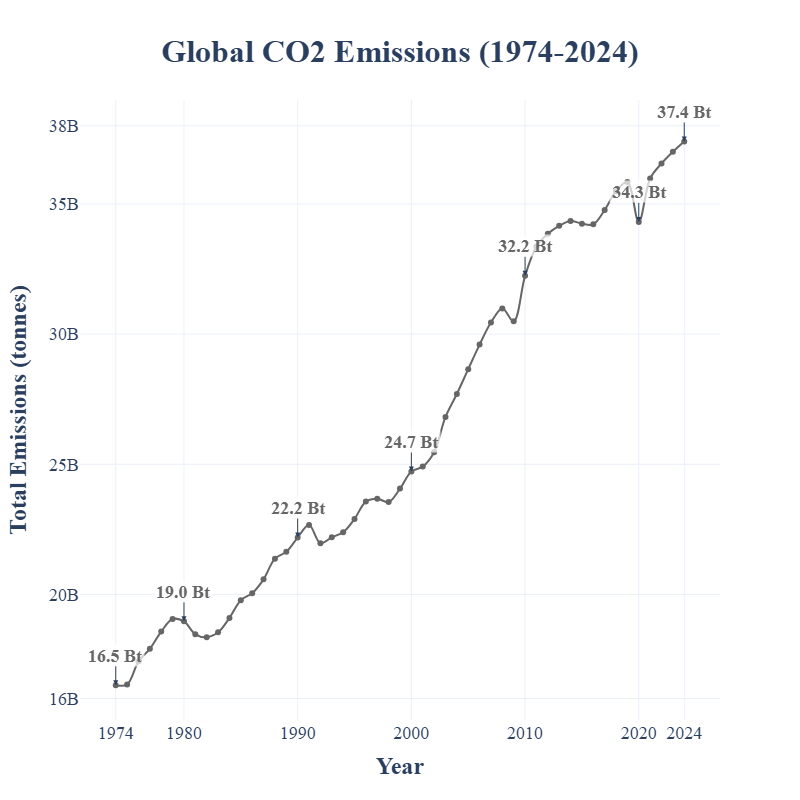

In [15]:
emission_line_chart = sql("""
SELECT year, SUM(emissions_total) AS total_emissions FROM emission_raw
INNER JOIN world_clean ON emission_raw.Code = world_clean.code
WHERE year BETWEEN 1974 AND 2024
GROUP BY year
ORDER BY year
""")

fig = px.line(emission_line_chart,
              x='Year',
              y='total_emissions',
              title='<b>Global CO2 Emissions (1974-2024)<b>',
              line_shape='spline',
              markers=True,
              color_discrete_sequence=[px.colors.qualitative.Dark2[7]]
             )

fig.update_layout(
    title_font_size=32,
    font=dict(family='Lekton'),
    title_x=0.5,
    title_y=0.95,
    xaxis_title_text='<b>Year</b>',
    yaxis_title_text='<b>Total Emissions (tonnes)</b>',
    xaxis=dict(title_font_size=24, tickfont_size=18, tickvals=[1974, 1980, 1990, 2000, 2010, 2020, 2024]),
    yaxis=dict(title_font_size=24, tickfont_size=18, tickvals=[1.6e10, 2e10, 2.5e10, 3e10, 3.5e10, 3.8e10]),
    template='plotly_white',
    width=800, height=800
)

for index, row in emission_line_chart.iterrows():
    if row['Year'] % 10 == 0 or row['Year'] in [1974, 2024]:
        fig.add_annotation(
            x=row['Year'],
            y=row['total_emissions'],
            text=f"<b>{row['total_emissions']/1e9:.1f} Bt<b>", # Format as billion tonnes
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=1,
            ax=0,
            ay=-30,
            font=dict(size=18, color=px.colors.qualitative.Dark2[7]),
            bgcolor='rgba(255, 255, 255, 0.7)' # Add a background for readability
        )
fig.show()

## 2. Who is the biggest responsible for that emissions?

Bar plot emissions per continent (1974 vs 2024)

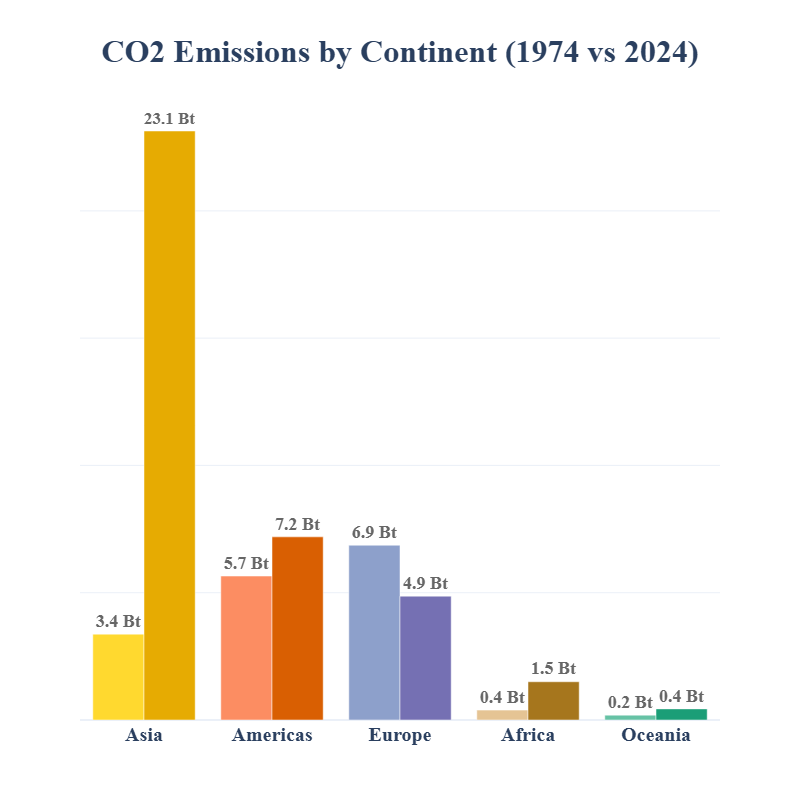

In [14]:
# This time we perform the query using pandas tools
emissions_all = (
    emission_raw
    .merge(world_clean, left_on="Code", right_on="code")
    .groupby(["Year", "continent"], as_index=False)
    .agg({"emissions_total": "sum"})
    .rename(columns={"continent": "Entity"})
)

# We use this to order the bars for the visualization
order_2024 = (
    emissions_all[emissions_all["Year"] == 2024]
    .sort_values("emissions_total", ascending=False)["Entity"]
    .tolist()
)

# We set color palette for continents
continent_colors_2024 = {
    'Asia': px.colors.qualitative.Dark2[5],
    'Africa': px.colors.qualitative.Dark2[6],
    'Oceania': px.colors.qualitative.Dark2[0],
    'Americas': px.colors.qualitative.Dark2[1],
    'Europe': px.colors.qualitative.Dark2[2],
}

# For past data we use lighter colors of the same palette
continent_colors_1974 = {
    'Asia': px.colors.qualitative.Set2[5],
    'Africa': px.colors.qualitative.Set2[6],
    'Oceania': px.colors.qualitative.Set2[0],
    'Americas': px.colors.qualitative.Set2[1],
    'Europe': px.colors.qualitative.Set2[2],
}

fig = go.Figure() # Reset figure

for year in [1974, 2024]:
    df_year = emissions_all[emissions_all["Year"] == year]
    if year == 1974: colors = [continent_colors_1974.get(e, "#cccccc") for e in df_year["Entity"]]
    else: colors = [continent_colors_2024.get(e, "#999999") for e in df_year["Entity"]]

    fig.add_trace(go.Bar(
        x=df_year["Entity"],
        y=df_year["emissions_total"],
        name=str(year),
        marker_color=colors,
        width=0.4,
        text=["<b>" + str(val) + " Bt</b>" for val in (df_year["emissions_total"] / 1e9).round(1)],
        textposition="outside",
        textfont=dict(size=18, family="Lekton", color=px.colors.qualitative.Dark2[7])
    ))

fig.update_layout(
    barmode="group",
    width=800,
    height=800,
    title="<b>CO2 Emissions by Continent (1974 vs 2024)</b>",
    title_x=0.5,
    title_y=0.95,
    title_font_size=32,
    xaxis=dict(
        tickfont=dict(size=20, weight="bold"),
        categoryorder="array",
        categoryarray=order_2024
    ),
    yaxis=dict(showticklabels=False, showline=False, ticks=""),
    font=dict(family="Lekton"),
    template="plotly_white",
    legend=dict(title="Year", font=dict(size=16), orientation="h", yanchor="top", y=1, xanchor="center", x=0.1),
    showlegend=False
)

fig.show()


## 3. Is it worth to have such inefficient economics?

- Scatter plot total emissions vs gdp per capita per continent (2024)

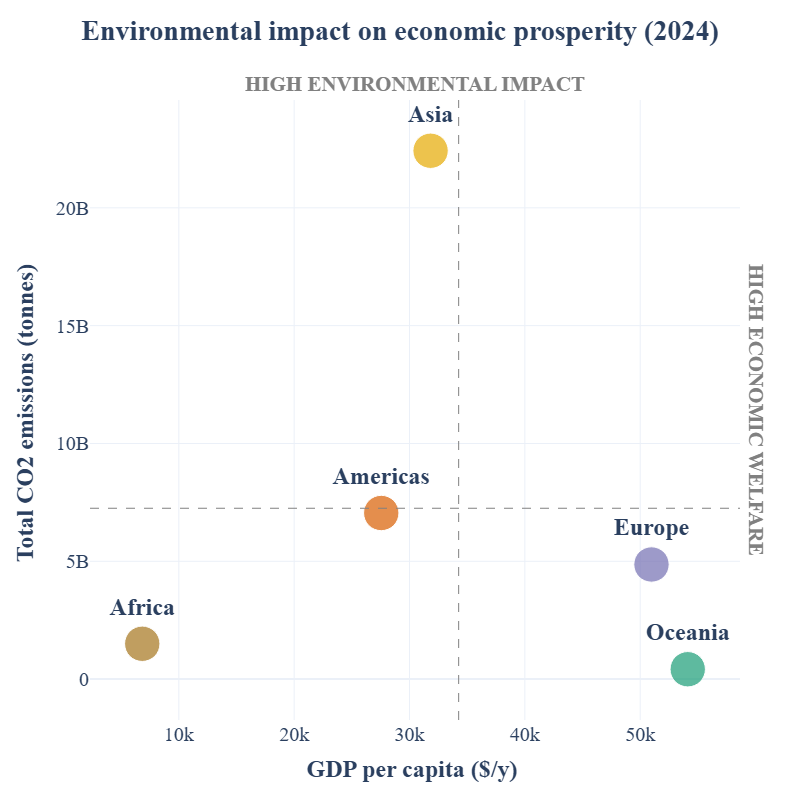

IN DETAIL

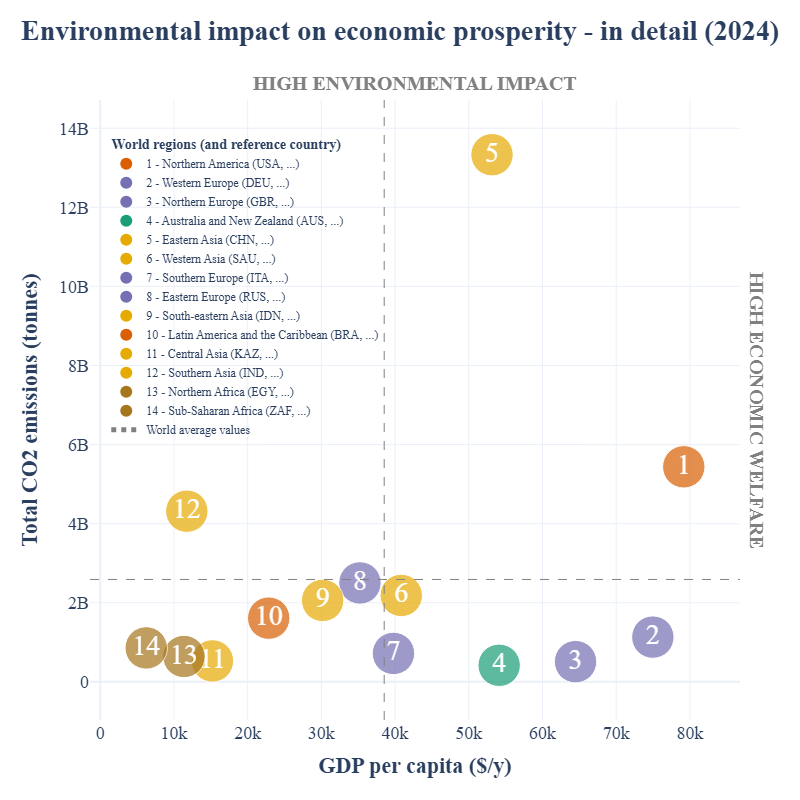

In [17]:
# Query
emission_gdp_impact = sql("""
SELECT wc.continent, AVG(gdp_raw.ny_gdp_pcap_pp_kd) as total_gdp_per_capita, SUM(er.emissions_total) as emissions_total FROM gdp_raw
INNER JOIN world_clean as wc ON gdp_raw.Code = wc.code
INNER JOIN emission_raw as er ON gdp_raw.Code = er.Code
WHERE gdp_raw.year = 2024 AND er.year = 2024 AND wc.sub_region NOT IN ("Polynesia", "Melanesia", "Micronesia")
GROUP BY wc.continent
ORDER BY total_gdp_per_capita DESC
""")

display(emission_gdp_impact.head())

# Plot
fig = px.scatter(
    emission_gdp_impact,
    y='emissions_total',
    x='total_gdp_per_capita',
    color='continent',
    color_discrete_map=continent_colors_2024, # Same color map as before
    size=[200]*len(emission_gdp_impact),
    size_max=25,
    hover_name='continent',
    text='continent'
)

fig.update_layout(
    width=800,
    height=800,
    title="<b>Environmental impact on economic prosperity (2024)</b>",
    title_x=0.5,
    title_y=0.975,
    title_font=dict(size=28, family="Lekton"),
    xaxis=dict(
        title="<b>GDP per capita ($/y) </b>",
        title_font=dict(size=24, family="Lekton"),
        tickfont=dict(size=20, family="Lekton")
    ),
    yaxis=dict(
        title="<b>Total CO2 emissions (tonnes) </b>",
        title_font=dict(size=24, family="Lekton"),
        tickfont=dict(size=20, family="Lekton")
    ),
    font=dict(family="Lekton"),
    template="plotly_white",
    showlegend=False,
    margin=dict(t=100, r=60, b=80, l=90)
)

fig.update_traces(
    textposition="top center",
    textfont=dict(size=24, family="Lekton", weight="bold")
)


# We calculate the axis center using data mean values
x_center = emission_gdp_impact['total_gdp_per_capita'].mean()
y_center = emission_gdp_impact['emissions_total'].mean()

fig.add_shape(
    type="line",
    x0=x_center, x1=x_center,
    y0=0, y1=1,
    xref="x", yref="paper",
    line=dict(width=1, dash="dash", color="gray")
)

fig.add_shape(
    type="line",
    x0=0, x1=1,
    y0=y_center, y1=y_center,
    xref="paper", yref="y",
    line=dict(width=1, dash="dash", color="gray")
)

# We describe emission and economic using annotations
fig.add_annotation(
    x=0.5, y=1,
    xref="paper", yref="paper",
    text="HIGH ENVIRONMENTAL IMPACT",
    showarrow=False,
    font=dict(size=21, family="Lekton", color="gray", weight="bold"),
    xshift=0,
    yshift=30
)

fig.add_annotation(
    x=1, y=0.5,
    xref="paper", yref="paper",
    text="HIGH ECONOMIC WELFARE",
    showarrow=False,
    font=dict(size=21, family="Lekton", color="gray", weight="bold"),
    xshift=30,
    yshift=0,
    textangle=90
)

fig.show()

,continent,total_gdp_per_capita,emissions_total
0,Oceania,54122.432000,4.192118e+08
1,Europe,50980.004425,4.864308e+09
2,Asia,31826.416474,2.242118e+10
3,Americas,27550.164628,7.049231e+09
4,Africa,6829.198097,1.499649e+09


In [20]:
# Query
## We exclude some regions to be coherent with following share electricity data that does not contains their data

gdp_rank = sql("""
SELECT wc.continent, wc.sub_region, AVG(gdp_raw.ny_gdp_pcap_pp_kd) AS total_gdp_per_capita, SUM(er.emissions_total) AS emissions_total,
    (
        SELECT er2.code
        FROM emission_raw er2
        INNER JOIN world_clean wc2 ON er2.Code = wc2.code
        WHERE er2.year = 2024
          AND wc2.sub_region = wc.sub_region
        ORDER BY er2.emissions_total DESC
        LIMIT 1
    ) AS top_country FROM gdp_raw
INNER JOIN world_clean wc ON gdp_raw.Code = wc.code
INNER JOIN emission_raw er ON gdp_raw.Code = er.Code
WHERE gdp_raw.year = 2024 AND er.year = 2024  AND wc.sub_region NOT IN ("Polynesia", "Melanesia", "Micronesia")
GROUP BY wc.sub_region
ORDER BY total_gdp_per_capita DESC;

""")

gdp_rank = gdp_rank.reset_index(drop=True)
gdp_rank['label_num'] = gdp_rank.index + 1

display(gdp_rank.head())






# Plot
fig = px.scatter(
    gdp_rank,
    y='emissions_total',
    x='total_gdp_per_capita',
    color='continent',
    color_discrete_map=continent_colors_2024,
    size=[300]*len(gdp_rank),   # marker più grandi
    size_max=30,
    hover_name='sub_region',
    text='label_num'
)

# Remove continent legend (must be before other legend)
fig.for_each_trace(lambda t: t.update(showlegend=False))

# Linee di riferimento
x_center = gdp_rank['total_gdp_per_capita'].mean()
y_center = gdp_rank['emissions_total'].mean()

fig.add_shape(type="line", x0=x_center, x1=x_center, y0=0, y1=1,
              xref="x", yref="paper", line=dict(width=1, dash="dash", color="gray"))
fig.add_shape(type="line", x0=0, x1=1, y0=y_center, y1=y_center,
              xref="paper", yref="y", line=dict(width=1, dash="dash", color="gray"))

for i, row in gdp_rank.iterrows():
    fig.add_trace(go.Scatter(
        x=[None], y=[None],
        mode="markers",
        marker=dict(size=24, color=continent_colors_2024[row['continent']]),
        showlegend=True,
        name=f"{row['label_num']} - {row['sub_region']} ({row['top_country']}, ...)"
    ))


# Trace fittizia per mostrare la linea tratteggiata in legenda
fig.add_trace(go.Scatter(
    x=[None], y=[None],
    mode="lines",
    line=dict(color="gray", width=0.5, dash="dot"),  # stesso stile delle linee di riferimento
    showlegend=True,
    name="World average values"   # testo accanto alla linea
))

fig.update_layout(
    width=800,
    height=800,
    title="<b>Environmental impact on economic prosperity - in detail (2024)</b>",
    title_x=0.5,
    title_y=0.975,
    title_font=dict(size=28, family="Lekton"),
    xaxis=dict(title="<b>GDP per capita ($/y)</b>",
               title_font=dict(size=22, family="Lekton"),
               tickfont=dict(size=18, family="Lekton")),
    yaxis=dict(title="<b>Total CO2 emissions (tonnes)</b>",
               title_font=dict(size=22, family="Lekton"),
               tickfont=dict(size=18, family="Lekton")),
    font=dict(family="Lekton"),
    template="plotly_white",
    showlegend=True,
    margin=dict(t=100, r=60, b=80, l=90),
    legend=dict(
        title="<b> World regions (and reference country)</b>",
        font=dict(size=12, family="Lekton"),
        orientation="v",
        x=0.025, y=0.95,
        xanchor="left",
        yanchor="top",
        bgcolor="rgba(0,0,0,0)"
    )
)


fig.update_traces(
    textposition="middle center",
    textfont=dict(size=28, family="Lekton", color="white")
)


# We describe emission and economic using annotations
fig.add_annotation(
    x=0.5, y=1,
    xref="paper", yref="paper",
    text="HIGH ENVIRONMENTAL IMPACT",
    showarrow=False,
    font=dict(size=20, family="Lekton", color="gray", weight="bold"),
    xshift=0,
    yshift=30
)

fig.add_annotation(
    x=1, y=0.5,
    xref="paper", yref="paper",
    text="HIGH ECONOMIC WELFARE",
    showarrow=False,
    font=dict(size=20, family="Lekton", color="gray", weight="bold"),
    xshift=30,
    yshift=0,
    textangle=90
)

fig.show()

,continent,sub_region,total_gdp_per_capita,emissions_total,top_country,label_num
0,Americas,Northern America,79168.810000,5.438010e+09,USA,1
1,Europe,Western Europe,74971.766714,1.132195e+09,DEU,2
2,Europe,Northern Europe,64485.623300,5.107532e+08,GBR,3
3,Oceania,Australia and New Zealand,54122.432000,4.192118e+08,AUS,4
4,Asia,Eastern Asia,53151.935400,1.332998e+10,CHN,5


## 4. What is the key for the success?

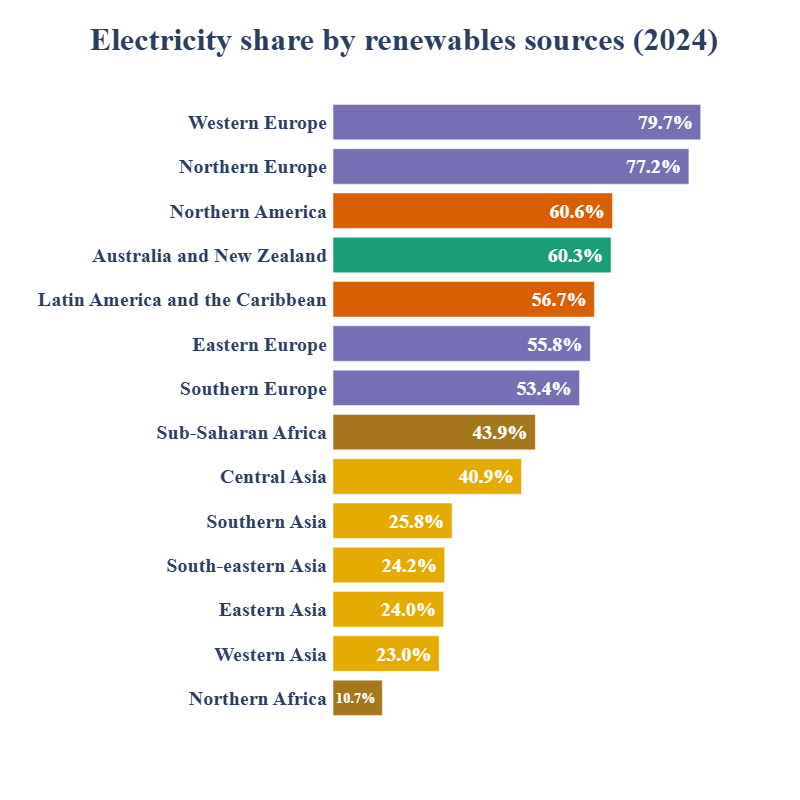

In [22]:
share_rank = sql(f"""
SELECT wc.sub_region, wc.continent, AVG({"+".join(renew_cols)}) as renewable_sources FROM share_raw
INNER JOIN world_clean as wc ON share_raw.Code = wc.code
WHERE Year = 2024
GROUP BY wc.sub_region
ORDER BY renewable_sources DESC
""")

display(share_rank)

# Get unique sub_regions and create a color map with shades of blue
#share_rank['sub_region'] = share_rank['sub_region'].fillna("Unknown")
#share_rank['country'] = share_rank['country'].replace('Netherlands, Kingdom of the', 'Netherland')
#share_rank['country'] = share_rank['country'].replace('United Kingdom of Great Britain and Northern Ireland', 'United Kingdom')

fig = px.bar(share_rank,
             x='renewable_sources',
             y='sub_region',
             color='continent',
             orientation='h',
             title='<b> Electricity share by renewables sources (2024)</b>',
             text='renewable_sources', # Value to display on the bar
             color_discrete_map=continent_colors_2024 # Apply the custom blue color map
            )

# Update traces for text formatting
fig.update_traces(texttemplate='%{text:.1f}% ', textposition='inside', textfont=dict(size=20, family='Lekton', weight='bold', color="white"))

# Prendi i valori originali delle sub_region
tick_vals = share_rank['sub_region'].tolist()
# Crea le etichette con la lettera A accanto
tick_text = [f"{val} " for val in tick_vals]

fig.update_layout(
    title_x=0.5,  # Center the title
    title_font_size=32,  # Larger title
    xaxis=dict(
        title_text='',
        showticklabels=False,
        showgrid=False,
        zeroline=False
    ),
    yaxis=dict(
        title_text='',
        showticklabels=True,
        tickfont=dict(size=20, weight='bold'),
        categoryorder='total ascending',
        showgrid=False,
        showline=False,
        tickvals=tick_vals,   # valori originali
        ticktext=tick_text    # etichette modificate solo nel layout
    ),
    width=800,
    height=800,  # Increased height to ensure all country names are visible
    font=dict(family='Lekton'),  # Set global font family
    showlegend=False,
    legend=dict(
        orientation="h",  # Horizontal legend
        yanchor="bottom",
        y=-0.2,  # Position legend below the plot area (adjust as needed)
        xanchor="center",
        x=0,
        title_text='<b>Sub-Region</b>',
        font=dict(size=18)
    ),
    legend_font_size=18,
    legend_title_font_size=20,
    template='plotly_white'  # Set white background
)

fig.show()

,sub_region,continent,renewable_sources
0,Western Europe,Europe,79.714355
1,Northern Europe,Europe,77.169145
2,Northern America,Americas,60.597300
3,Australia and New Zealand,Oceania,60.276452
4,Latin America and the Caribbean,Americas,56.677928
5,Eastern Europe,Europe,55.790540
6,Southern Europe,Europe,53.445175
7,Sub-Saharan Africa,Africa,43.872730
8,Central Asia,Asia,40.873700
9,Southern Asia,Asia,25.816838


## 5. What is the composition of the electricty mix and what are the main used renewables?

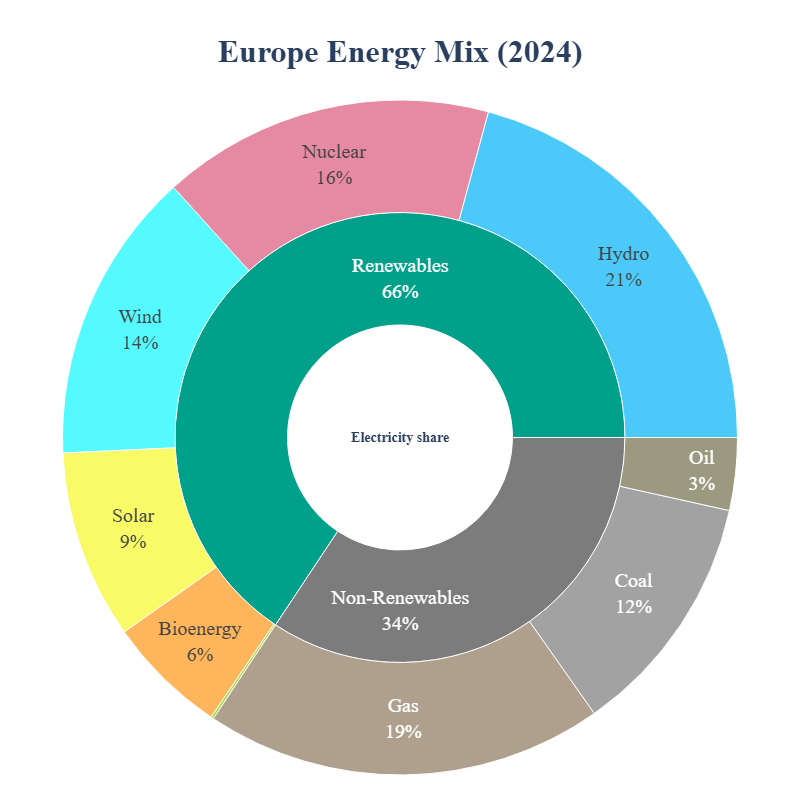

ASIA

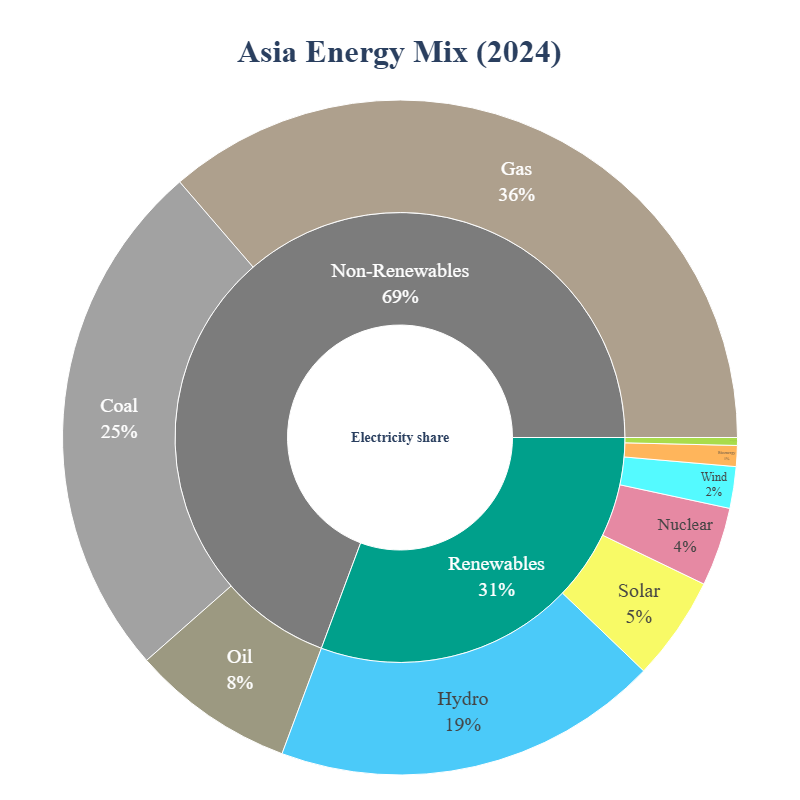

In [24]:
# 1. Get data for European countries in 2024
europe_2024_share_df = sql("""
SELECT sr.gas, sr.oil, sr.coal, sr.nuclear, sr.wind, sr.hydro, sr.other_renewables_excluding_bioenergy, sr.solar, sr.bioenergy FROM share_raw AS sr
INNER JOIN world_clean AS wc ON sr.Code = wc.code
WHERE sr.Year = 2024 AND wc.continent = 'Europe'
""")

# Calculate the average share for each source across European countries
numeric_cols = ['gas', 'oil', 'coal', 'nuclear', 'wind', 'hydro', 'other_renewables_excluding_bioenergy', 'solar', 'bioenergy']
europe_avg_share = europe_2024_share_df[numeric_cols].mean().to_dict()

# Define categories (Nuclear included in Non-Renewables as it's not renewable)
renew_sources = ['wind', 'hydro', 'other_renewables_excluding_bioenergy', 'solar', 'bioenergy', 'nuclear']
non_renew_sources = ['gas', 'oil', 'coal']

# 2. Prepare data for the sunburst chart
sunburst_data_list = []

# Root node
sunburst_data_list.append(dict(
    id="Total",
    labels="<b>Electricity share<b>",
    parents="",
    source_type="Total",
    value=sum(europe_avg_share[s] for s in renew_sources + non_renew_sources if s in europe_avg_share)
))

# Level 1: Renewables
total_renew_val = sum(europe_avg_share[s] for s in renew_sources if s in europe_avg_share)
sunburst_data_list.append(dict(
    id="Renewables",
    labels="Renewables",
    parents="Total",
    source_type="Renewables",
    value=total_renew_val
))
# Level 2: Individual Renewable Sources
for source in renew_sources:
    if source in europe_avg_share and europe_avg_share[source] > 0:
        sunburst_data_list.append(dict(
            id=source,
            labels=source.replace('_', ' ').title(),
            parents="Renewables",
            source_type="Renewable Source",
            value=europe_avg_share[source]
        ))

# Level 1: Non-Renewables
total_non_renew_val = sum(europe_avg_share[s] for s in non_renew_sources if s in europe_avg_share)
sunburst_data_list.append(dict(
    id="Non-Renewables",
    labels="Non-Renewables",
    parents="Total",
    source_type="Non-Renewables",
    value=total_non_renew_val
))
# Level 2: Individual Non-Renewable Sources
for source in non_renew_sources:
    if source in europe_avg_share and europe_avg_share[source] > 0:
        sunburst_data_list.append(dict(
            id=source,
            labels=source.replace('_', ' ').title(),
            parents="Non-Renewables",
            source_type="Non-Renewable Source",
            value=europe_avg_share[source]
        ))

sunburst_df = pd.DataFrame(sunburst_data_list)

# Ensure values are numeric
sunburst_df['value'] = pd.to_numeric(sunburst_df['value'])


energy_source_color_map = {
    'hydro': px.colors.qualitative.Light24[13],
    'nuclear': px.colors.qualitative.Light24[10],
    'wind': px.colors.qualitative.Light24[5],
    'solar': px.colors.qualitative.Light24[6],
    'other_renewables_excluding_bioenergy': px.colors.qualitative.Light24[19],
    'bioenergy': px.colors.qualitative.Light24[7],

    'gas': px.colors.qualitative.Antique[9],
    'oil': px.colors.qualitative.Antique[3],
    'coal': px.colors.qualitative.Antique[10],

    'Total': 'white', # Grey for the total
    'Renewables': px.colors.qualitative.Dark24[10], # A distinct color for the Renewables slice
    'Non-Renewables': px.colors.qualitative.Antique[10], # A distinct color for the Non-Renewables slice
}

# 3. Create the sunburst chart
fig = px.sunburst(sunburst_df,
                  ids='id',
                  names='labels',
                  parents='parents',
                  values='value',
                  title='<b> Europe Energy Mix (2024) </b>',
                  color='id', # Color based on the 'id' column for specific colors
                  color_discrete_map=energy_source_color_map,
                  branchvalues='total'
                 )

# 4. Apply aesthetic enhancements (similar to previous charts)
fig.update_layout(
    title_x=0.5,
    title_y=0.95, # Adjust title_y to move title higher
    width=800,
    height=800, # Increased height to ensure all country names are visible
    title_font_size=32, # Adjusted to match previous plots
    font=dict(family='Lekton', size=14),
    margin = dict(t=100, l=25, r=25, b=25),
    hovermode='closest'
)

fig.update_traces(
    textinfo='label+percent root', # Show label and percentage relative to parent ### SE SCRIVO PERCENT PARENT MOSTRO QUELLA RELATIVA
    insidetextfont=dict(family='Lekton', size=20), # Lekton font for inside text
    insidetextorientation='horizontal',
    hovertemplate='<b>%{label}</b><br>Share: %{value:.1f}%<br><i>(%{percent:.1%}) of %{parent}</i>' ### SE SCRIVO PERCENT MOSTRO QUELLA GLOBALE o se scrivo percentParent quella relativa
)

fig.show()

In [25]:
# 1. Get data for European countries in 2024
europe_2024_share_df = sql("""
SELECT sr.gas, sr.oil, sr.coal, sr.nuclear, sr.wind, sr.hydro, sr.other_renewables_excluding_bioenergy, sr.solar, sr.bioenergy FROM share_raw AS sr
INNER JOIN world_clean AS wc ON sr.Code = wc.code
WHERE sr.Year = 2024 AND wc.continent = 'Asia'
""")

# Calculate the average share for each source across European countries
numeric_cols = ['gas', 'oil', 'coal', 'nuclear', 'wind', 'hydro', 'other_renewables_excluding_bioenergy', 'solar', 'bioenergy']
europe_avg_share = europe_2024_share_df[numeric_cols].mean().to_dict()

# Define categories (Nuclear included in Non-Renewables as it's not renewable)
renew_sources = ['wind', 'hydro', 'other_renewables_excluding_bioenergy', 'solar', 'bioenergy', 'nuclear']
non_renew_sources = ['gas', 'oil', 'coal']

# 2. Prepare data for the sunburst chart
sunburst_data_list = []

# Root node
sunburst_data_list.append(dict(
    id="Total",
    labels="<b>Electricity share<b>",
    parents="",
    source_type="Total",
    value=sum(europe_avg_share[s] for s in renew_sources + non_renew_sources if s in europe_avg_share)
))

# Level 1: Renewables
total_renew_val = sum(europe_avg_share[s] for s in renew_sources if s in europe_avg_share)
sunburst_data_list.append(dict(
    id="Renewables",
    labels="Renewables",
    parents="Total",
    source_type="Renewables",
    value=total_renew_val
))
# Level 2: Individual Renewable Sources
for source in renew_sources:
    if source in europe_avg_share and europe_avg_share[source] > 0:
        sunburst_data_list.append(dict(
            id=source,
            labels=source.replace('_', ' ').title(),
            parents="Renewables",
            source_type="Renewable Source",
            value=europe_avg_share[source]
        ))

# Level 1: Non-Renewables
total_non_renew_val = sum(europe_avg_share[s] for s in non_renew_sources if s in europe_avg_share)
sunburst_data_list.append(dict(
    id="Non-Renewables",
    labels="Non-Renewables",
    parents="Total",
    source_type="Non-Renewables",
    value=total_non_renew_val
))
# Level 2: Individual Non-Renewable Sources
for source in non_renew_sources:
    if source in europe_avg_share and europe_avg_share[source] > 0:
        sunburst_data_list.append(dict(
            id=source,
            labels=source.replace('_', ' ').title(),
            parents="Non-Renewables",
            source_type="Non-Renewable Source",
            value=europe_avg_share[source]
        ))

sunburst_df = pd.DataFrame(sunburst_data_list)

# Ensure values are numeric
sunburst_df['value'] = pd.to_numeric(sunburst_df['value'])


energy_source_color_map = {
    'hydro': px.colors.qualitative.Light24[13],
    'nuclear': px.colors.qualitative.Light24[10],
    'wind': px.colors.qualitative.Light24[5],
    'solar': px.colors.qualitative.Light24[6],
    'other_renewables_excluding_bioenergy': px.colors.qualitative.Light24[19],
    'bioenergy': px.colors.qualitative.Light24[7],

    'gas': px.colors.qualitative.Antique[9],
    'oil': px.colors.qualitative.Antique[3],
    'coal': px.colors.qualitative.Antique[10],

    'Total': 'white', # Grey for the total
    'Renewables': px.colors.qualitative.Dark24[10], # A distinct color for the Renewables slice
    'Non-Renewables': px.colors.qualitative.Antique[10], # A distinct color for the Non-Renewables slice
}

# 3. Create the sunburst chart
fig = px.sunburst(sunburst_df,
                  ids='id',
                  names='labels',
                  parents='parents',
                  values='value',
                  title='<b> Asia Energy Mix (2024) </b>',
                  color='id', # Color based on the 'id' column for specific colors
                  color_discrete_map=energy_source_color_map,
                  branchvalues='total'
                 )

# 4. Apply aesthetic enhancements (similar to previous charts)
fig.update_layout(
    title_x=0.5,
    title_y=0.95, # Adjust title_y to move title higher
    width=800,
    height=800, # Increased height to ensure all country names are visible
    title_font_size=32, # Adjusted to match previous plots
    font=dict(family='Lekton', size=14),
    margin = dict(t=100, l=25, r=25, b=25),
    hovermode='closest'
)

fig.update_traces(
    textinfo='label+percent root', # Show label and percentage relative to parent ### SE SCRIVO PERCENT PARENT MOSTRO QUELLA RELATIVA
    insidetextfont=dict(family='Lekton', size=20), # Lekton font for inside text
    insidetextorientation='horizontal',
    hovertemplate='<b>%{label}</b><br>Share: %{value:.1f}%<br><i>(%{percent:.1%}) of %{parent}</i>' ### SE SCRIVO PERCENT MOSTRO QUELLA GLOBALE o se scrivo percentParent quella relativa
)

fig.show()